# 단순한 챗봇을 만들자. 
## 이 코드에서 알아야 할 개념
- State
- Node
- Edge

In [1]:
%pip install langgraph langchain langchain_openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

llm.invoke([
    HumanMessage(content="안녕하세요!"),
])

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e4fa3702df', 'id': 'chatcmpl-BDslTlc1EtAnCL70LK4El9iZoRimb', 'finish_reason': 'stop', 'logprobs': None}, id='run-b5019d37-63ef-4223-b4a9-ae14001a0bfd-0', usage_metadata={'input_tokens': 10, 'output_tokens': 11, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## STATE
- 현재 상태를 담아두기 위해 사용

In [3]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):	#①
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.   #②
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.  #③
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]	#②

# StateGraph 클래스를 사용하여 State 타입의 그래프를 생성합니다.
graph_builder = StateGraph(State) #④

## Node
- 하나의 에이전트라고 봐도 무방

In [4]:
def generate(state: State):	#①
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [llm.invoke(state["messages"])]}	#② llm이 생성한 응답메시지를 state에 추가하고 반환

graph_builder.add_node("generate", generate)	#③

## LangGraph라 부르는 이유:
- 각각의 agent (node)를 edge로 연결하는 방식이기 때문.
- 이번 예제는 START - generate - END 로 간략한 형태


### Edge

In [5]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

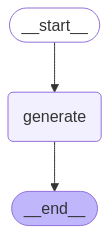

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

In [7]:
response = graph.invoke({"messages": ["안녕하세요! 저는 이성용입니다"]})

print(type(response))
response

<class 'langgraph.pregel.io.AddableValuesDict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다', additional_kwargs={}, response_metadata={}, id='dfffdb24-71c8-483e-a97b-9af8dd4c323b'),
  AIMessage(content='안녕하세요, 이성용님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 15, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDslfQxE3ngXwcDtWqvyLWabgvjjL', 'finish_reason': 'stop', 'logprobs': None}, id='run-7a3838c1-c157-48aa-bfeb-eac1d00a397b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 22, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [8]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다', additional_kwargs={}, response_metadata={}, id='dfffdb24-71c8-483e-a97b-9af8dd4c323b'),
  AIMessage(content='안녕하세요, 이성용님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 15, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDslfQxE3ngXwcDtWqvyLWabgvjjL', 'finish_reason': 'stop', 'logprobs': None}, id='run-7a3838c1-c157-48aa-bfeb-eac1d00a397b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 22, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='제 이름을 아시나요?', additiona

- stream 출력 하고 싶으면 graph.invoke 대신 graph.stream으로 하면 됩니다. 

In [9]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 다양한 요소에 의해 영향을 받아왔습니다. 두 나라의 관계는 전통적으로 문화, 경제, 정치, 역사적 사건 등 여러 측면에서 형성되어 왔습니다.

1. **역사적 배경**:
   - **일제 강점기 (1910-1945)**: 한국은 1910년부터 1945년까지 일본의 식민지 지배를 받았습니다. 이 시기에 많은 한국인들이 강제 노동, 문화적 억압, 일본어 강제 교육 등을 경험했으며, 이로 인해 두 나라 간의 감정이 매우 상처받은 상태입니다.
   - **제2차 세계대전 이후**: 전쟁이 끝난 후 한국은 1945년에 해방되었고, 1948년에 대한민국이 수립되었습니다. 한국 전쟁(1950-1953) 후에도 일본과의 관계는 냉전 상황 속에서 복잡하게 얽혀 있었습니다.

2. **경제적 관계**:
   - **교역과 투자**: 1965년 한일기본조약 체결 이후, 한국과 일본 간의 경제적 교류가 활발해졌습니다. 일본은 한국의 주요 투자국이자 교역 파트너 중 하나입니다. 한국의 반도체, 자동차 산업 등에서 일본의 기술과 자본이 중요한 역할을 했습니다.
   - **기술 협력**: 두 나라 간의 기술 협력도 매우 중요하며, 특히 전자제품 및 자동차 분야에서 상호 의존적인 관계를 형성하고 있습니다.

3. **정치적 관계**:
   - **영토 문제**: 독도(일본명: 다케시마)를 둘러싼 영토 분쟁은 두 나라 간의 긴장을 야기하는 주요 원인 중 하나입니다.
   - **역사 인식**: 일본의 과거 전쟁 범죄에 대한 인식 차이, 예를 들어 위안부 문제나 강제 징용 문제 등은 여전히 해결되지 않은 주요 이슈로 남아 있습니다. 이러한 이슈들은 국민 감정에 크게 작용하며 양국 관계에 부정적인 영향을 미칩니다.

4. **문화적 관계**:
   - **문화 교류**: 한국과 일본은 서로의 문화에 대한 관심이 높아져 있으며, K-팝, 드라마, 영화 등 한국의 대중문화가 일본에서 인기를 끌고 있습니다. 반대로 일본의 애니메이션과 만화도 한국에서 큰 인